In [1]:
## DGU-MLDL-final project 【라월 2022127039】
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset
from collections import Counter
import random
import math
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

path = '../input/pokemonclassification/PokemonData'
data_transforms = transforms.Compose([
    transforms.Resize(size=(224,224), antialias=True),
#     transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.IMAGENET, interpolation=transforms.InterpolationMode.BILINEAR),
   
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5],[0.5])
])
image_datasets = datasets.ImageFolder(path,data_transforms) 
train_size = int(0.8 * len(image_datasets)) 
validation_size = int(0.1 * len(image_datasets)) 
test_size = len(image_datasets) - train_size - validation_size 
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size, validation_size, test_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16,shuffle = True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=4,shuffle = True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4,shuffle = True, drop_last=True)
class_counts = Counter(train_dataset.dataset.targets)
train_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float).cuda() 
class_counts = Counter(validation_dataset.dataset.targets)
validation_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float).cuda() 
class_counts = Counter(test_dataset.dataset.targets)
test_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float).cuda()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


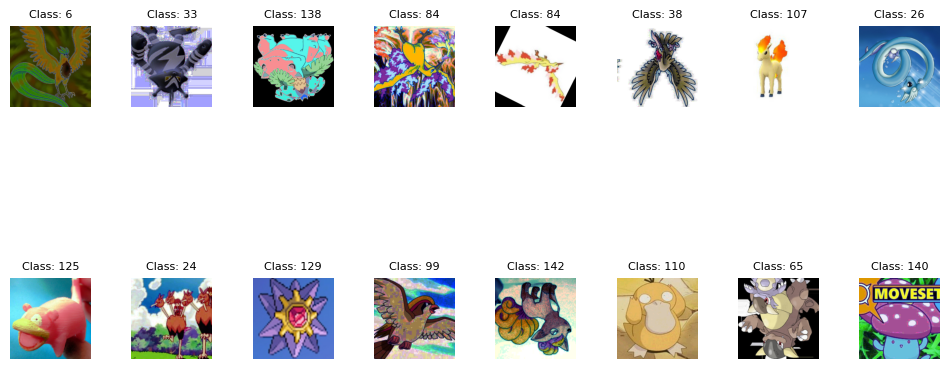

In [2]:
# 从训练集中获取一批图像样本
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 定义反归一化函数，将归一化后的张量还原为图像
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# 可视化原始图像和经过预处理后的图像
fig, axes = plt.subplots(2, len(images)//2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)  # 调整子图之间的间距

for i, ax in enumerate(axes.flat):
    original_img = denormalize(images[i].cpu()).numpy().transpose(1, 2, 0)
    ax.imshow(original_img)
    ax.axis('off')
    ax.set_title(f'Class: {labels[i].item()}', fontsize=8)  # 调整字体大小

plt.show()


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class RestNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        output = self.conv1(x)
        output = F.relu(self.bn1(output))
        output = self.conv2(output)
        output = self.bn2(output)
        return F.relu(x + output)


class RestNetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(RestNetDownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride[0], padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride[1], padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.extra = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride[0], padding=0),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        extra_x = self.extra(x)
        output = self.conv1(x)
        out = F.relu(self.bn1(output))

        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(extra_x + out)


class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(RestNetBasicBlock(64, 64, 1),
                                    RestNetBasicBlock(64, 64, 1))

        self.layer2 = nn.Sequential(RestNetDownBlock(64, 128, [2, 1]),
                                    RestNetBasicBlock(128, 128, 1))

        self.layer3 = nn.Sequential(RestNetDownBlock(128, 256, [2, 1]),
                                    RestNetBasicBlock(256, 256, 1))

        self.layer4 = nn.Sequential(RestNetDownBlock(256, 512, [2, 1]),
                                    RestNetBasicBlock(512, 512, 1))

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Linear(512, 150)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(x.shape[0], -1)
        out = self.fc(out)
        return out


In [4]:
import torch
from torchvision import models
from torch import nn

from torchvision.models import VGG16_BN_Weights

class Vgg16(nn.Module):
    def __init__(self, num_classes=150):
        super(Vgg16, self).__init__()
        vgg16_net = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)

        self.features = vgg16_net.features
        self.avgpool = vgg16_net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        f_x = self.features(x)
        a_x = self.avgpool(f_x)
        fla_x = torch.flatten(a_x, 1)
        c_x = self.classifier(fla_x)
        return c_x


class vgg19(nn.Module):
    def __init__(self, num_classes):
        super(vgg19, self).__init__()
        vgg19_net = models.vgg19_bn(pretrained=True)
        self.features = vgg19_net.features
        self.avgpool = vgg19_net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
import torch.nn as nn
import torchvision.models as models

class GoogLeNet(nn.Module):
    def __init__(self, num_classes=150):
        super(GoogLeNet, self).__init__()
        self.googlenet = models.googlenet(pretrained=True)
        in_features = self.googlenet.fc.in_features
        self.googlenet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.googlenet(x)

In [6]:
model = ResNet18().cuda()
train_criterion = torch.nn.CrossEntropyLoss(weight=train_weights)
validation_criterion = torch.nn.CrossEntropyLoss(weight=validation_weights)
test_criterion = torch.nn.CrossEntropyLoss(weight=test_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 80

In [7]:
for epoch in range(epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    total_train_loss = 0

    for index, (data, target) in enumerate(train_loader):
        X = data.cuda()
        Y = target.cuda()
        output = model(X)
        loss = train_criterion(output, Y)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == Y).sum().item()
        total_samples += len(Y)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(Y.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_train_loss = total_train_loss / len(train_loader)

    print("Epoch: {}, Training Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        epoch + 1, avg_train_loss, accuracy, f1, precision, recall))

    model.eval()
    with torch.no_grad():
        total_valid_loss = 0
        total_valid_samples = 0

        all_valid_predictions = []
        all_valid_targets = []

        for X, Y in validation_loader:
            X = X.cuda()
            Y = Y.cuda()
            output = model(X)
            valid_loss = validation_criterion(output, Y)
            total_valid_loss += valid_loss.item()
            total_valid_samples += len(Y)

            _, predicted = torch.max(output, 1)
            all_valid_predictions.extend(predicted.cpu().numpy())
            all_valid_targets.extend(Y.cpu().numpy())

        accuracy_valid = accuracy_score(all_valid_targets, all_valid_predictions)
        f1_valid = f1_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        precision_valid = precision_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        recall_valid = recall_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        avg_valid_loss = total_valid_loss / len(validation_loader)

        print("Epoch: {}, Validation Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
            epoch + 1, avg_valid_loss, accuracy_valid, f1_valid, precision_valid, recall_valid))

Epoch: 1, Training Metrics - Loss: 4.9480, Accuracy: 0.0176, F1-score: 0.0124, Precision: 0.1242, Recall: 0.0176
Epoch: 1, Validation Metrics - Loss: 4.8245, Accuracy: 0.0118, F1-score: 0.0048, Precision: 0.7528, Recall: 0.0118
Epoch: 2, Training Metrics - Loss: 4.7077, Accuracy: 0.0295, F1-score: 0.0244, Precision: 0.0791, Recall: 0.0295
Epoch: 2, Validation Metrics - Loss: 4.7103, Accuracy: 0.0544, F1-score: 0.0420, Precision: 0.6232, Recall: 0.0544
Epoch: 3, Training Metrics - Loss: 4.6030, Accuracy: 0.0409, F1-score: 0.0334, Precision: 0.1013, Recall: 0.0409
Epoch: 3, Validation Metrics - Loss: 4.5449, Accuracy: 0.0382, F1-score: 0.0282, Precision: 0.5709, Recall: 0.0382
Epoch: 4, Training Metrics - Loss: 4.4844, Accuracy: 0.0473, F1-score: 0.0391, Precision: 0.0521, Recall: 0.0473
Epoch: 4, Validation Metrics - Loss: 4.4295, Accuracy: 0.0559, F1-score: 0.0358, Precision: 0.5226, Recall: 0.0559
Epoch: 5, Training Metrics - Loss: 4.4207, Accuracy: 0.0621, F1-score: 0.0510, Precision

In [8]:
model.eval()  # test case 
test_loss = 0
correct = 0
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    all_predictions = []
    all_targets = []

    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        
        test_loss += test_criterion(output, target).item()  # sum up batch loss

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    accuracy_test = accuracy_score(all_targets, all_predictions)
    f1_test = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision_test = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall_test = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_test_loss = total_test_loss / len(test_loader)

    print("Test Metrics - Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        accuracy_test, f1_test, precision_test, recall_test))

Test Metrics - Accuracy: 0.7412, F1-score: 0.7413, Precision: 0.8047, Recall: 0.7412


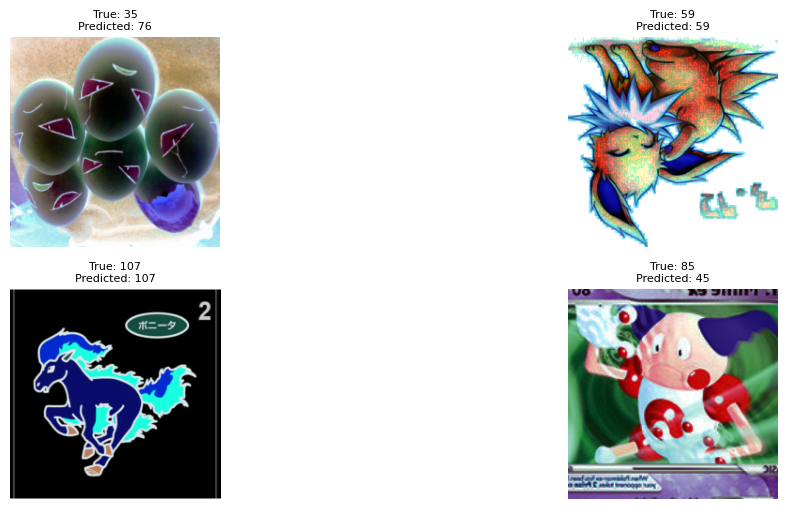

In [9]:
# Set the model to evaluation mode
model.eval()

# Get a batch from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.cuda(), labels.cuda()

# Perform inference
with torch.no_grad():
    outputs = model(images)

# Convert predictions and labels to numpy arrays
predictions = outputs.argmax(dim=1).cpu().numpy()
labels = labels.cpu().numpy()

# Plot the images with predictions
fig, axes = plt.subplots(2, len(images)//2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)  # Adjust the spacing between subplots

for i, ax in enumerate(axes.flat):
    # Display the image
    image = images[i].cpu().numpy().transpose(1, 2, 0)
    ax.imshow((image + 1) / 2)  # Denormalize the image
    ax.axis('off')

    # Display the true label and predicted label
    true_label = labels[i]
    predicted_label = predictions[i]
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=8)

plt.show()

In [10]:
model = Vgg16().cuda()
train_criterion = torch.nn.CrossEntropyLoss(weight=train_weights)
validation_criterion = torch.nn.CrossEntropyLoss(weight=validation_weights)
test_criterion = torch.nn.CrossEntropyLoss(weight=test_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
epochs = 80

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]  


In [11]:
for epoch in range(80):
    model.train()
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    total_train_loss = 0

    for index, (data, target) in enumerate(train_loader):
        X = data.cuda()
        Y = target.cuda()
        output = model(X)
        loss = train_criterion(output, Y)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == Y).sum().item()
        total_samples += len(Y)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(Y.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_train_loss = total_train_loss / len(train_loader)

    print("Epoch: {}, Training Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        epoch + 1, avg_train_loss, accuracy, f1, precision, recall))

    model.eval()
    with torch.no_grad():
        total_valid_loss = 0
        total_valid_samples = 0

        all_valid_predictions = []
        all_valid_targets = []

        for X, Y in validation_loader:
            X = X.cuda()
            Y = Y.cuda()
            output = model(X)
            valid_loss = validation_criterion(output, Y)
            total_valid_loss += valid_loss.item()
            total_valid_samples += len(Y)

            _, predicted = torch.max(output, 1)
            all_valid_predictions.extend(predicted.cpu().numpy())
            all_valid_targets.extend(Y.cpu().numpy())

        accuracy_valid = accuracy_score(all_valid_targets, all_valid_predictions)
        f1_valid = f1_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        precision_valid = precision_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        recall_valid = recall_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        avg_valid_loss = total_valid_loss / len(validation_loader)

        print("Epoch: {}, Validation Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
            epoch + 1, avg_valid_loss, accuracy_valid, f1_valid, precision_valid, recall_valid))

Epoch: 1, Training Metrics - Loss: 5.0103, Accuracy: 0.0093, F1-score: 0.0056, Precision: 0.3218, Recall: 0.0093
Epoch: 1, Validation Metrics - Loss: 5.0009, Accuracy: 0.0162, F1-score: 0.0056, Precision: 0.8286, Recall: 0.0162
Epoch: 2, Training Metrics - Loss: 4.9860, Accuracy: 0.0147, F1-score: 0.0111, Precision: 0.1800, Recall: 0.0147
Epoch: 2, Validation Metrics - Loss: 4.9411, Accuracy: 0.0235, F1-score: 0.0121, Precision: 0.8128, Recall: 0.0235
Epoch: 3, Training Metrics - Loss: 4.9151, Accuracy: 0.0244, F1-score: 0.0178, Precision: 0.1393, Recall: 0.0244
Epoch: 3, Validation Metrics - Loss: 4.7840, Accuracy: 0.0824, F1-score: 0.0556, Precision: 0.7596, Recall: 0.0824
Epoch: 4, Training Metrics - Loss: 4.8042, Accuracy: 0.0367, F1-score: 0.0286, Precision: 0.0963, Recall: 0.0367
Epoch: 4, Validation Metrics - Loss: 4.6326, Accuracy: 0.1676, F1-score: 0.1409, Precision: 0.7371, Recall: 0.1676
Epoch: 5, Training Metrics - Loss: 4.6782, Accuracy: 0.0581, F1-score: 0.0460, Precision

In [12]:
model.eval()  # test case 
test_loss = 0
correct = 0
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    all_predictions = []
    all_targets = []

    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        test_loss += test_criterion(output, target).item()  # sum up batch loss

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    accuracy_test = accuracy_score(all_targets, all_predictions)
    f1_test = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision_test = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall_test = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_test_loss = total_test_loss / len(test_loader)

    print("Test Metrics - Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        accuracy_test, f1_test, precision_test, recall_test))

Test Metrics - Accuracy: 0.8956, F1-score: 0.8933, Precision: 0.9181, Recall: 0.8956


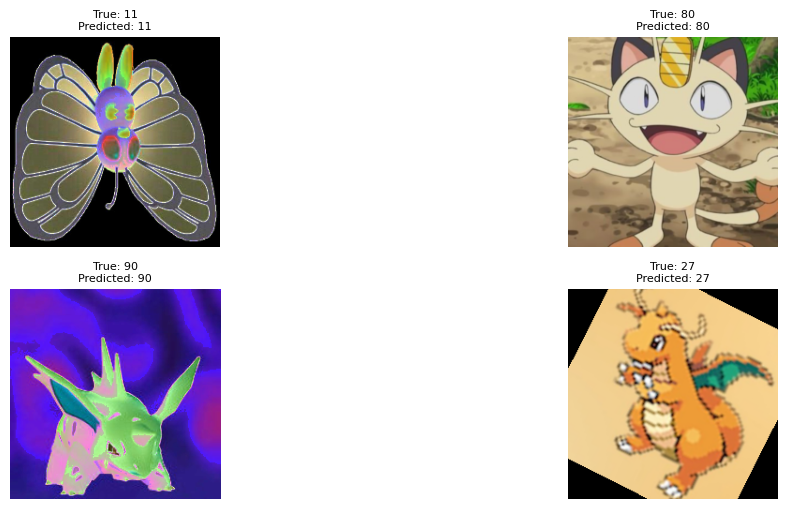

In [13]:
# Set the model to evaluation mode
model.eval()

# Get a batch from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.cuda(), labels.cuda()

# Perform inference
with torch.no_grad():
    outputs = model(images)

# Convert predictions and labels to numpy arrays
predictions = outputs.argmax(dim=1).cpu().numpy()
labels = labels.cpu().numpy()

# Plot the images with predictions
fig, axes = plt.subplots(2, len(images)//2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)  # Adjust the spacing between subplots

for i, ax in enumerate(axes.flat):
    # Display the image
    image = images[i].cpu().numpy().transpose(1, 2, 0)
    ax.imshow((image + 1) / 2)  # Denormalize the image
    ax.axis('off')

    # Display the true label and predicted label
    true_label = labels[i]
    predicted_label = predictions[i]
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=8)

plt.show()

In [14]:
model = GoogLeNet().cuda()
train_criterion = torch.nn.CrossEntropyLoss(weight=train_weights)
validation_criterion = torch.nn.CrossEntropyLoss(weight=validation_weights)
test_criterion = torch.nn.CrossEntropyLoss(weight=test_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 80

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 95.0MB/s]


In [15]:
for epoch in range(80):
    model.train()
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    total_train_loss = 0

    for index, (data, target) in enumerate(train_loader):
        X = data.cuda()
        Y = target.cuda()
        output = model(X)
        loss = train_criterion(output, Y)
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == Y).sum().item()
        total_samples += len(Y)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(Y.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_train_loss = total_train_loss / len(train_loader)

    print("Epoch: {}, Training Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        epoch + 1, avg_train_loss, accuracy, f1, precision, recall))

    model.eval()
    with torch.no_grad():
        total_valid_loss = 0
        total_valid_samples = 0

        all_valid_predictions = []
        all_valid_targets = []

        for X, Y in validation_loader:
            X = X.cuda()
            Y = Y.cuda()
            output = model(X)
            valid_loss = validation_criterion(output, Y)
            total_valid_loss += valid_loss.item()
            total_valid_samples += len(Y)

            _, predicted = torch.max(output, 1)
            all_valid_predictions.extend(predicted.cpu().numpy())
            all_valid_targets.extend(Y.cpu().numpy())

        accuracy_valid = accuracy_score(all_valid_targets, all_valid_predictions)
        f1_valid = f1_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        precision_valid = precision_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        recall_valid = recall_score(all_valid_targets, all_valid_predictions, average='weighted', zero_division=1)
        avg_valid_loss = total_valid_loss / len(validation_loader)

        print("Epoch: {}, Validation Metrics - Loss: {:.4f}, Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
            epoch + 1, avg_valid_loss, accuracy_valid, f1_valid, precision_valid, recall_valid))

Epoch: 1, Training Metrics - Loss: 4.6289, Accuracy: 0.1168, F1-score: 0.1120, Precision: 0.1829, Recall: 0.1168
Epoch: 1, Validation Metrics - Loss: 3.7415, Accuracy: 0.3912, F1-score: 0.3539, Precision: 0.6906, Recall: 0.3912
Epoch: 2, Training Metrics - Loss: 3.3175, Accuracy: 0.4509, F1-score: 0.4199, Precision: 0.5230, Recall: 0.4509
Epoch: 2, Validation Metrics - Loss: 2.3749, Accuracy: 0.6044, F1-score: 0.5958, Precision: 0.7875, Recall: 0.6044
Epoch: 3, Training Metrics - Loss: 2.2422, Accuracy: 0.6507, F1-score: 0.6372, Precision: 0.6783, Recall: 0.6507
Epoch: 3, Validation Metrics - Loss: 1.6136, Accuracy: 0.7691, F1-score: 0.7666, Precision: 0.8303, Recall: 0.7691
Epoch: 4, Training Metrics - Loss: 1.5268, Accuracy: 0.7647, F1-score: 0.7611, Precision: 0.7715, Recall: 0.7647
Epoch: 4, Validation Metrics - Loss: 1.0940, Accuracy: 0.8088, F1-score: 0.8064, Precision: 0.8578, Recall: 0.8088
Epoch: 5, Training Metrics - Loss: 1.0815, Accuracy: 0.8341, F1-score: 0.8332, Precision

In [16]:
model.eval()  # test case 
test_loss = 0
correct = 0
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    all_predictions = []
    all_targets = []

    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        output = model(data)
        test_loss += test_criterion(output, target).item()  # sum up batch loss

        _, predicted = torch.max(output, 1)
        total_correct += (predicted == target).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    accuracy_test = accuracy_score(all_targets, all_predictions)
    f1_test = f1_score(all_targets, all_predictions, average='weighted', zero_division=1)
    precision_test = precision_score(all_targets, all_predictions, average='weighted', zero_division=1)
    recall_test = recall_score(all_targets, all_predictions, average='weighted', zero_division=1)
    avg_test_loss = total_test_loss / len(test_loader)

    print("Test Metrics - Accuracy: {:.4f}, F1-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(
        accuracy_test, f1_test, precision_test, recall_test))

Test Metrics - Accuracy: 0.9162, F1-score: 0.9144, Precision: 0.9289, Recall: 0.9162


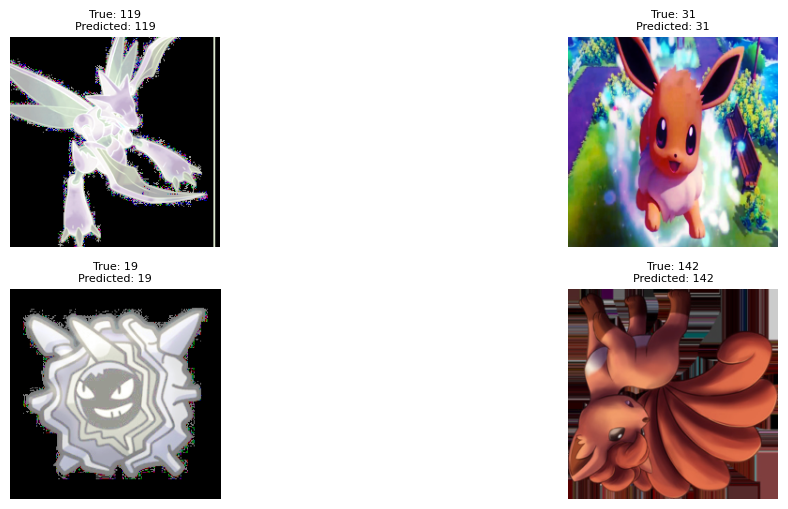

In [17]:
# Set the model to evaluation mode
model.eval()

# Get a batch from the test set
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.cuda(), labels.cuda()

# Perform inference
with torch.no_grad():
    outputs = model(images)

# Convert predictions and labels to numpy arrays
predictions = outputs.argmax(dim=1).cpu().numpy()
labels = labels.cpu().numpy()

# Plot the images with predictions
fig, axes = plt.subplots(2, len(images)//2, figsize=(12, 6))
plt.subplots_adjust(wspace=0.5)  # Adjust the spacing between subplots

for i, ax in enumerate(axes.flat):
    # Display the image
    image = images[i].cpu().numpy().transpose(1, 2, 0)
    ax.imshow((image + 1) / 2)  # Denormalize the image
    ax.axis('off')

    # Display the true label and predicted label
    true_label = labels[i]
    predicted_label = predictions[i]
    ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=8)

plt.show()
